In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
dataDir = "data/"  # Directory where our data is stored

In [3]:
dtypes = {'display_id' : np.int32, 'ad_id': np.int32, 'clicked': np.int8}
dfTrain = pd.read_csv(dataDir + "clicks_train.csv", dtype=dtypes)

In [4]:
dfTrain.head()

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0


In [5]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87141731 entries, 0 to 87141730
Data columns (total 3 columns):
display_id    int32
ad_id         int32
clicked       int8
dtypes: int32(2), int8(1)
memory usage: 747.9 MB


In [6]:
globalClickMean = dfTrain['clicked'].mean()

In [5]:
dfClicked = dfTrain[dfTrain['clicked'] == 1]

In [8]:
dfClicked.head()

,display_id,ad_id,clicked
2,1,144739,1
9,2,308455,1
14,3,228657,1
17,4,153623,1
25,5,326514,1


In [9]:
dfStats = dfClicked.groupby('ad_id')['clicked'].agg({'clicks' : 'count'}).reset_index()

In [10]:
dfStats.head()

,ad_id,clicks
0,2,1
1,3,11
2,4,4
3,7,985
4,8,4


In [11]:
dfViews = dfTrain.groupby('ad_id')['ad_id'].agg({'views' : 'count'}).reset_index()

In [12]:
dfStats = dfStats.merge(dfViews, on='ad_id', how='left')

In [13]:
dfStats.head()

,ad_id,clicks,views
0,2,1,22
1,3,11,161
2,4,4,32
3,7,985,3406
4,8,4,28


## Why the 4?

This is from the initial notebook online that used a 12 instead.  We think this is due to a Bayes' calculation of the conditional probability. Four is the average number of ads in a display (2-12 ads per display with 60% of the displays having either 4 or 6 ads per display)

In [14]:
dfStats['click_ratio'] = (dfStats['clicks'] + 4.0*globalClickMean) / (4.0 + dfStats['views'])

In [15]:
dfStats.head()

,ad_id,clicks,views,click_ratio
0,2,1,22,0.068253
1,3,11,161,0.071361
2,4,4,32,0.132627
3,7,985,3406,0.289083
4,8,4,28,0.149206


In [16]:
dfStats['penalty'] = -1.0 / np.exp(dfStats['views'])

In [17]:
print('The maximum penalty is {:.4f} and the minimum penalty is {:.4f}'.format(
        dfStats['penalty'].max(), dfStats['penalty'].min()))

The maximum penalty is -0.0000 and the minimum penalty is -0.3679


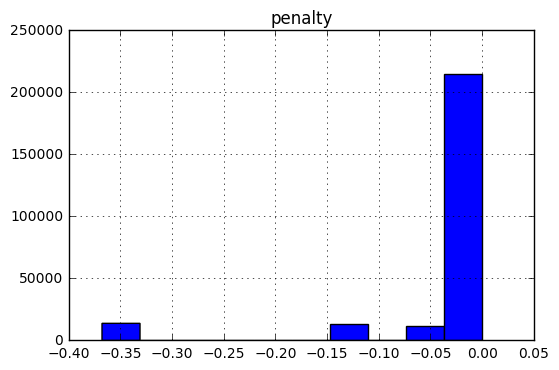

In [18]:
dfStats.hist('penalty');

In [19]:
dfStats['likelihood'] = dfStats['click_ratio'] + dfStats['penalty']

In [20]:
print('The maximum likelihood is {:.4f} and the minimum likelihood is {:.4f}'.format(
        dfStats['likelihood'].max(), dfStats['likelihood'].min()))

The maximum likelihood is 0.8922 and the minimum likelihood is -0.0130


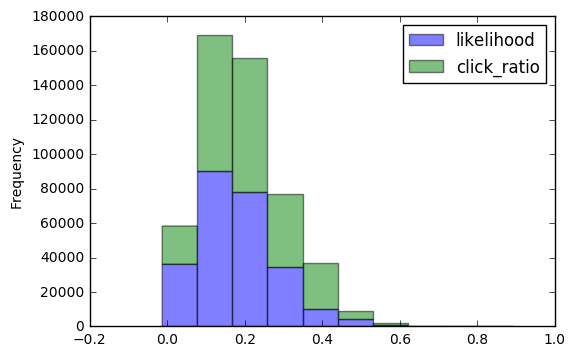

In [21]:
dfStats[['likelihood', 'click_ratio']].plot.hist(alpha=0.5, stacked=True);

## Save the order to file

In [22]:
dfStats = dfStats.sort_values('likelihood', ascending=False)

In [23]:
dfStats.tail(10)

,ad_id,clicks,views,click_ratio,penalty,likelihood
141198,298874,1,1,0.354916,-0.367879,-0.012963
141181,298833,1,1,0.354916,-0.367879,-0.012963
141179,298823,1,1,0.354916,-0.367879,-0.012963
141157,298792,1,1,0.354916,-0.367879,-0.012963
141141,298761,1,1,0.354916,-0.367879,-0.012963
141139,298750,1,1,0.354916,-0.367879,-0.012963
141131,298723,1,1,0.354916,-0.367879,-0.012963
240112,502958,1,1,0.354916,-0.367879,-0.012963
141118,298682,1,1,0.354916,-0.367879,-0.012963
254135,548019,1,1,0.354916,-0.367879,-0.012963


In [24]:
dfStats['ad_id'].to_csv(dataDir + "clickedOrder.csv", index=False, header=True)